In [70]:
!pip install holidays -q
!pip install workalendar -q
!pip install fasttext -q

You should consider upgrading via the 'D:\conda\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'D:\conda\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'D:\conda\python.exe -m pip install --upgrade pip' command.


In [1]:
%%capture
import catboost
import pandas as pd
import numpy as np
import fasttext
import fasttext.util
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('bmh')

# Fasttext model downloading and reduction
#dlmode = fasttext.util.download_model("ru")
#model = "cc.ru.300.bin"
#ft_model = fasttext.load_model(model)
#fasttext.util.reduce_model(ft_model, 100)
#ft_model.save_model("cc.ru.100.bin")


In [2]:
file_name = r"../TenderHack_Москва_train_data.xlsx" 
columns = ['id', 'status', 'name', 'okpd2','kpgz','region','nmck','price','date','participans','bet','inn']

spgz_name = "../spgz_kpgz.xlsx"
df_kpgz = pd.read_excel(spgz_name)
df_kpgz = df_kpgz['КПГЗ']

df = pd.read_excel(file_name, header=None, names=columns, skiprows=1)
df['okpd2'] = df['okpd2'].fillna(0)
prod_df = df
prod_df = prod_df.drop('id', axis='columns')
prod_df.dtypes

status          object
name            object
okpd2           object
kpgz            object
region          object
nmck           float64
price          float64
date            object
participans      int64
bet              int64
inn             object
dtype: object

In [3]:
prod_df.head()

status                                               name okpd2  \
0      Завершена                                 СТУЛЬЯ УЧЕНИЧЕСКИЕ     0   
1  Не состоялась                    МЕДИЦИНСКИЕ РАСХОДНЫЕ МАТЕРИАЛЫ     0   
2      Завершена                             Видеокарта Palit PCI-E     0   
3      Завершена  ТОВАРЫ ИНФОРМАЦИОННО-ТЕХНОЛОГИЧЕСКИЕ, СРЕДСТВА...     0   
4      Завершена                                      Пинцет острый     0   

                                                kpgz  region      nmck  \
0                      01.06.01.03.01;01.06.01.03.01  Москва  596790.0   
1                   01.02.10.50.33;01.02.10.43.05.01  Москва    4964.9   
2                                        01.13.17.08  Москва  462000.0   
3  01.13.11.03.02;01.13.04.04.06.05;01.10.04.04.0...  Москва  505555.0   
4                                  01.02.10.06.48.04  Москва    2000.0   

       price                     date  participans  bet  \
0  593806.05  2021-06-30 11:20:05.720            1    1   
1       0.00  2022-10-04 09:16:04.770            0    0   
2  311850.00  2021-07-01 13:23:09.177            6   65   
3  460042.90  2021-03-16 10:42:20.810            6   18   
4    1980.00  2022-05-26 11:04:42.597            2    2   

                                inn  
0  d8912494ba2edd3bfeba55206a78a0f5  
1  237a5c57a66f02f8deb152e21f33863a  
2  040f1570117a744d529f4675f827a50f  
3  c00c03dca0274fe43fc34e974434a927  
4  cc997efa7a6742b6119a3c253a084e80

In [4]:
prod_df.nunique()

status              4
name            76947
okpd2            7621
kpgz            74161
region             10
nmck           124569
price          157474
date           244941
participans        36
bet               197
inn              3335
dtype: int64

In [5]:
"""
Завершена
Не состоялась
Снята с публикации
Активна"""

prod_df["status"].value_counts()
cleanup_nums = {"status": {"Завершена": 1, "Не состоялась": 0, 'Снята с публикации': 0, 'Активна': -1}}
prod_df = prod_df.replace(cleanup_nums)

prod_df.head()

print(prod_df["status"].unique())

[ 1  0 -1]


In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for cat_var in ['inn']:
    prod_df[cat_var] = le.fit_transform(prod_df[cat_var])  
    
print(prod_df["inn"].unique())
print(prod_df["inn"].max())

[2808  443   56 ... 2689 1099  492]
3334


In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for cat_var in ['region']:
    prod_df[cat_var] = le.fit_transform(prod_df[cat_var])  
    
print(prod_df["region"].unique())
print(prod_df["region"].max())

[2 4 5 7 9 6 1 0 3 8]
9


In [8]:
model = "../cc.ru.300.bin"

def get_names(kpgzs: str, mapping: dict) -> str:
    try:
        kpgzs = kpgzs.strip()
        result = ""
        for kpgz in kpgzs.split(";"):
            result+=" "+mapping[kpgz]
        return result.strip()
    except Exception as e:
        return ""

def get_embeddings(s: str, ft_model) -> list:
    try:
        return ft_model.get_sentence_vector(s)
    except:
        return []
    
ft_model = fasttext.load_model(model)
mapping = {}
for kpgz, name in zip(df_kpgz.str.split().str[0], df_kpgz.str.split().str[1:].str.join(" ")):
    mapping[kpgz] = name

    
import json
with open("../data-20160929T0100.json", "r") as f:
    okpd2 = json.load(f)
    
okpd2_dict = {}

for odin_okpd in okpd2:
    try:
        okpd2_dict[odin_okpd["Kod"]] = odin_okpd["Name"]
    except Exception as e:
        pass

kpgz = prod_df.kpgz.map(lambda x: get_names(x, mapping=mapping)).to_list()
okpd = prod_df.okpd2.map(lambda x: get_names(x, mapping=okpd2_dict)).to_list()
names = prod_df.name.to_list()
texts = [" ".join([i,j,z]) for i,j,z in zip(kpgz, okpd, names)]

prod_df["kpgz"] = pd.DataFrame({"kpgz":list(map(lambda x: get_embeddings(x, ft_model), texts))})
#prod_df["kpgz"] = prod_df.kpgz.map(lambda x: get_names_embeddings(x, mapping=mapping, ft_model=ft_model))
#prod_df["okpd2_text"] = prod_df.okpd2.map(lambda x:get_names_embeddings(x, mapping=okpd2_dict, ft_model=ft_model))

In [9]:
prod_df

status                                               name  \
0            1                                 СТУЛЬЯ УЧЕНИЧЕСКИЕ   
1            0                    МЕДИЦИНСКИЕ РАСХОДНЫЕ МАТЕРИАЛЫ   
2            1                             Видеокарта Palit PCI-E   
3            1  ТОВАРЫ ИНФОРМАЦИОННО-ТЕХНОЛОГИЧЕСКИЕ, СРЕДСТВА...   
4            1                                      Пинцет острый   
...        ...                                                ...   
246757       0                 Червячный хомут FORTISFLEX 110-130   
246758       0      Маскировочная сеть, "Стандарт", МС1-6,  3х6 м   
246759       0  ТРАНСПОРТНЫЕ СРЕДСТВА, РАСХОДНЫЕ МАТЕРИАЛЫ И З...   
246760       1                                             БЛАНКИ   
246761       0      Поставка радиотелефона Panasonic KX-TG1612RUH   

                                                    okpd2  \
0                                                       0   
1                                                       0   
2                                                       0   
3                                                       0   
4                                                       0   
...                                                   ...   
246757                                                  0   
246758                                                  0   
246759                                                  0   
246760                                                  0   
246761  26.30.23.000;26.30.23.000;26.30.23.000;26.30.2...   

                                                     kpgz  region      nmck  \
0       [0.058787882, -0.024700198, 0.020877648, -0.01...       2  596790.0   
1       [0.017644305, 0.00078524405, -0.016182233, 0.0...       2    4964.9   
2       [0.024858056, 0.023094011, 0.0067415102, -0.03...       2  462000.0   
3       [0.03967802, -0.044574197, 0.0073913345, -0.02...       2  505555.0   
4       [0.011361689, 0.015038267, -0.02646932, 0.0617...       2    2000.0   
...                                                   ...     ...       ...   
246757  [0.026930576, -0.011901853, 0.017534934, 0.016...       2    1000.0   
246758  [0.01907614, -0.04352456, 0.017033294, -0.0048...       2   60000.0   
246759  [0.017044669, -0.044309806, 0.0074499254, -0.0...       2  402582.6   
246760  [-0.0013911147, -0.025836049, -0.008570037, -0...       2   18600.0   
246761  [0.022340711, -0.07079152, 0.010804393, 0.0097...       5   26500.0   

            price                     date  participans  bet   inn  
0       593806.05  2021-06-30 11:20:05.720            1    1  2808  
1            0.00  2022-10-04 09:16:04.770            0    0   443  
2       311850.00  2021-07-01 13:23:09.177            6   65    56  
3       460042.90  2021-03-16 10:42:20.810            6   18  2476  
4         1980.00  2022-05-26 11:04:42.597            2    2  2639  
...           ...                      ...          ...  ...   ...  
246757       0.00  2022-03-30 12:23:15.930            0    0  2484  
246758       0.00  2022-10-03 09:42:05.507            0    0  2730  
246759       0.00  2021-04-20 09:13:12.317            0    0  1261  
246760   10500.00  2022-10-28 11:47:01.503            5    9  2842  
246761       0.00  2022-03-15 08:11:32.113            0    0  2131  

[246762 rows x 11 columns]

In [10]:
from datetime import date, datetime
prod_df['date'] = pd.to_datetime(prod_df.date, format='%Y-%m-%d %H:%M:%S')

def get_season(now):
    Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
    seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
               ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
               ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
               ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
               ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)


def get_season_delta(stamp):
    season_begin = {"winter":datetime(stamp.year+1,12,1),
                    "spring":datetime(stamp.year+1,3,1),
                    "summer":datetime(stamp.year+1,6,1),
                    "autumn":datetime(stamp.year+1,9,1)}
    current_season = get_season(stamp)
    season_delta = {"winter":None,
                    "spring":None,
                    "summer":None,
                    "autumn":None}
    for season in season_delta.keys():
        if(season == current_season):
            season_delta[season] = (stamp - season_begin[season]).days%365*-1
        else:
            season_delta[season] = (season_begin[season] - stamp).days%365
        season_delta[season]/=365
    return season_delta

timedeltas = prod_df.date.map(get_season_delta).to_numpy()

delta_dict = {"winter": [x["winter"] for x in timedeltas],
              "spring": [x["spring"] for x in timedeltas],
              "summer": [x["summer"] for x in timedeltas],
              "autumn": [x["autumn"] for x in timedeltas]}
              
prod_df = pd.concat([prod_df, pd.DataFrame(delta_dict)], axis=1)

df_dt = pd.DataFrame()
df_dt['date_hour'] = prod_df['date'].dt.hour
df_dt['date_minute'] = prod_df['date'].dt.minute
prod_df = pd.concat([prod_df, df_dt], axis=1)
prod_df = prod_df.drop('date', axis='columns')
prod_df

"""import holidays
from workalendar.europe import Russia

prod_df['date'] = pd.to_datetime(prod_df.date, format='%Y-%m-%d %H:%M:%S')
range_of_dates = pd.date_range("2022-01-01", "2023-12-31")
holidays = holidays.Russia(years=[2022, 2023]).items()

hdays = []
for day in holidays:
    hdays.append(day[0])

def season_from_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return '1'
    if date in seasons['summer']:
        return '2'
    if date in seasons['autumn']:
        return '3'
    else:
        return '4'

df_dt = pd.DataFrame()
df_dt['date_year'] = prod_df['date'].dt.year
df_dt['date_month'] = prod_df['date'].dt.month
df_dt['date_week'] = prod_df['date'].dt.isocalendar().week 
df_dt["date_weekend"] = df_dt["date_week"] >= 5
df_dt["date_weekend"] = df_dt["date_weekend"].astype(int)
df_dt['date_day'] = prod_df['date'].dt.day
df_dt['date_hour'] = prod_df['date'].dt.hour
df_dt['date_minute'] = prod_df['date'].dt.minute
df_dt['date_dayofweek'] = prod_df['date'].dt.dayofweek
df_dt['date_quarter'] = prod_df['date'].dt.quarter
#df_dt["delta_to_holiday"] = df['date'].isin(hdays)
df_dt["is_holiday"] = prod_df['date'].isin(hdays)
df_dt["is_holiday"] = df_dt["is_holiday"].astype(int)
df_dt['date_season'] = prod_df.date.map(season_from_date)
prod_df = pd.concat([prod_df, df_dt], axis=1)
prod_df = prod_df.drop('date', axis='columns')
prod_df""";

In [11]:
prod_df["price_percent"] = prod_df.price/prod_df.nmck

prod_df.loc[prod_df["status"] == 0, "price_percent"] = 1

### Создаем фичи из пространства векторов fasttext

In [12]:
new_df = prod_df
vecs = pd.DataFrame([list(x) for x in new_df.kpgz.to_numpy()])
new_df = pd.concat([new_df, vecs], axis=1)
new_df = new_df.drop('kpgz', axis = 1)
new_df = new_df.drop('name', axis='columns')
new_df = new_df.drop('okpd2', axis = 1)
new_df

status  region      nmck      price  participans  bet   inn    winter  \
0            1       2  596790.0  593806.05            1    1  2808  0.419178   
1            0       2    4964.9       0.00            0    0   443  0.156164   
2            1       2  462000.0  311850.00            6   65    56  0.416438   
3            1       2  505555.0  460042.90            6   18  2476 -0.287671   
4            1       2    2000.0    1980.00            2    2  2639  0.515068   
...        ...     ...       ...        ...          ...  ...   ...       ...   
246757       0       2    1000.0       0.00            0    0  2484  0.671233   
246758       0       2   60000.0       0.00            0    0  2730  0.158904   
246759       0       2  402582.6       0.00            0    0  1261  0.613699   
246760       1       2   18600.0   10500.00            5    9  2842  0.090411   
246761       0       5   26500.0       0.00            0    0  2131 -0.284932   

          spring    summer  ...       290       291       292       293  \
0       0.665753 -0.079452  ...  0.045931  0.023359 -0.043000 -0.060788   
1       0.402740  0.654795  ... -0.009904 -0.012167  0.007281 -0.023779   
2       0.663014 -0.082192  ... -0.074727  0.064505  0.025949  0.005360   
3       0.956164  0.208219  ...  0.006482  0.013508  0.024301  0.009117   
4      -0.235616  0.013699  ...  0.022139  0.040009  0.009069 -0.003029   
...          ...       ...  ...       ...       ...       ...       ...   
246757 -0.079452  0.169863  ...  0.000089  0.032062  0.015412  0.026036   
246758  0.405479  0.657534  ...  0.002029 -0.013433  0.018365 -0.035890   
246759 -0.136986  0.112329  ... -0.008442  0.019596  0.025737  0.027031   
246760  0.336986  0.589041  ...  0.039943 -0.035024 -0.000604  0.101420   
246761  0.958904  0.210959  ... -0.002081 -0.000569  0.014365 -0.001203   

             294       295       296       297       298       299  
0       0.024623  0.014417  0.021237  0.010465 -0.084160 -0.000674  
1       0.025588  0.022896  0.010836  0.021220 -0.044477 -0.010453  
2       0.028795  0.031768 -0.000573  0.021934 -0.047905 -0.022906  
3       0.008942  0.028956  0.022022  0.005983 -0.044323 -0.033721  
4       0.027222  0.052360 -0.055647 -0.003798 -0.039957 -0.007658  
...          ...       ...       ...       ...       ...       ...  
246757  0.029482  0.012823  0.025325  0.037929 -0.017262 -0.000780  
246758  0.017699  0.016220  0.018164  0.031051 -0.000481 -0.033154  
246759  0.049785  0.041713  0.011557  0.018567 -0.048579 -0.015681  
246760 -0.010713 -0.046873  0.026594  0.001003  0.029660 -0.019356  
246761 -0.006010 -0.003753  0.005510  0.013023 -0.029606 -0.006464  

[246762 rows x 314 columns]

In [13]:
#s = new_df.dtypes == "float64"
#for ind in s[s].index:
#    new_df.loc[:,ind] = new_df.loc[:,ind].astype(str)


# new_df = new_df.iloc[:,~new_df.columns.duplicated()]
# new_df

count    246762.000000
mean          3.240199
std           3.084245
min           0.000000
25%           1.000000
50%           2.000000
75%           5.000000
max          39.000000
Name: participans, dtype: float64


/tmp/ipykernel_242090/3834957543.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df['participans'], color='g', bins=100, hist_kws={'alpha': 0.4});


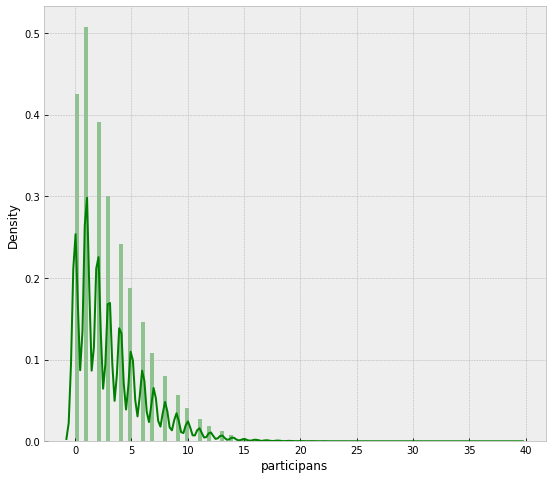

In [12]:
print(new_df['participans'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(new_df['participans'], color='g', bins=100, hist_kws={'alpha': 0.4});

### Нормализуем данные в датасете

In [168]:
# import pandas as pd
# from sklearn import preprocessing

# x = new_df.values
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# new_df = pd.DataFrame(x_scaled, columns=new_df.columns, index=new_df.index)
# new_df = new_df.replace(np.nan, 0)
# new_df

status    region      nmck     price  participans       bet       inn  \
0          1.0  0.222222  0.032704  0.032704     0.025641  0.005025  0.842232   
1          0.5  0.222222  0.000272  0.000000     0.000000  0.000000  0.132873   
2          1.0  0.222222  0.025318  0.017175     0.153846  0.326633  0.016797   
3          1.0  0.222222  0.027705  0.025337     0.153846  0.090452  0.742651   
4          1.0  0.222222  0.000110  0.000109     0.051282  0.010050  0.791542   
...        ...       ...       ...       ...          ...       ...       ...   
246757     0.5  0.222222  0.000055  0.000000     0.000000  0.000000  0.745051   
246758     0.5  0.222222  0.003288  0.000000     0.000000  0.000000  0.818836   
246759     0.5  0.222222  0.022062  0.000000     0.000000  0.000000  0.378224   
246760     1.0  0.222222  0.001019  0.000578     0.128205  0.045226  0.852430   
246761     0.5  0.555556  0.001452  0.000000     0.000000  0.000000  0.639172   

          winter    spring    summer  ...        90        91        92  \
0       0.552966  0.745263  0.176101  ...  0.392941  0.539298  0.537363   
1       0.349576  0.543158  0.737945  ...  0.684955  0.613783  0.463474   
2       0.550847  0.743158  0.174004  ...  0.460743  0.435294  0.337846   
3       0.006356  0.968421  0.396226  ...  0.576284  0.424240  0.295547   
4       0.627119  0.052632  0.247379  ...  0.559069  0.508236  0.429968   
...          ...       ...       ...  ...       ...       ...       ...   
246757  0.747881  0.172632  0.366876  ...  0.603080  0.508966  0.370679   
246758  0.351695  0.545263  0.740042  ...  0.566094  0.267498  0.345105   
246759  0.703390  0.128421  0.322851  ...  0.575197  0.428950  0.311625   
246760  0.298729  0.492632  0.687631  ...  0.689514  0.594911  0.326921   
246761  0.008475  0.970526  0.398323  ...  0.000000  0.000000  0.000000   

              93        94        95        96        97        98        99  
0       0.646281  0.378874  0.455435  0.501309  0.522564  0.516433  0.557331  
1       0.676372  0.317360  0.401642  0.608656  0.504922  0.421384  0.628249  
2       0.849753  0.490141  0.417404  0.521194  0.661725  0.476478  0.405752  
3       0.554579  0.505941  0.419983  0.422861  0.565306  0.495554  0.479600  
4       0.618183  0.404053  0.317152  0.614312  0.300094  0.700479  0.467505  
...          ...       ...       ...       ...       ...       ...       ...  
246757  0.665703  0.418529  0.564476  0.613823  0.591695  0.463776  0.429715  
246758  0.646044  0.410031  0.343655  0.554722  0.536929  0.525656  0.474928  
246759  0.579318  0.410538  0.483355  0.532284  0.603666  0.446138  0.378951  
246760  0.459338  0.465647  0.342699  0.615886  0.553357  0.589090  0.513889  
246761  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[246762 rows x 113 columns]

In [169]:
new_df.to_csv('test.csv')

In [170]:
new_df['participans'].unique()

array([0.02564103, 0.        , 0.15384615, 0.05128205, 0.20512821,
       0.17948718, 0.07692308, 0.48717949, 0.12820513, 0.1025641 ,
       0.23076923, 0.41025641, 0.25641026, 0.56410256, 0.35897436,
       0.30769231, 0.28205128, 0.38461538, 0.33333333, 0.58974359,
       0.43589744, 0.46153846, 0.53846154, 0.82051282, 0.51282051,
       0.76923077, 0.74358974, 0.64102564, 0.61538462, 0.71794872,
       0.84615385, 0.66666667, 0.87179487, 0.69230769, 1.        ,
       0.79487179])

In [13]:
df_num = new_df.select_dtypes(include = ['float64', 'int64'])
df_num_corr = df_num.corr()['participans']
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with participans:\n{}".format(len(golden_features_list), golden_features_list))

There is 3 strongly correlated values with participans:
participans      1.000000
bet              0.749631
price_percent   -0.694983
Name: participans, dtype: float64


### Пробуем предсказать статус закупки

In [36]:
X = new_df.drop(["participans", "price", "status", "bet","price_percent"], axis=1)
y = new_df["participans"]

# Cat features

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [32]:
from catboost import CatBoostRegressor
model_CBR = CatBoostRegressor(iterations=1000, learning_rate=0.05, )
model_CBR.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

print('CatBoostRegressor model is fitted: ' + str(model_CBR.is_fitted()))
print('CatBoostRegressor model parameters:')
print(model_CBR.get_params())

CatBoostRegressor model is fitted: True
CatBoostRegressor model parameters:
{'iterations': 1000, 'learning_rate': 0.05, 'loss_function': 'RMSE'}


Text(0.5, 1.0, 'Feature Importance')

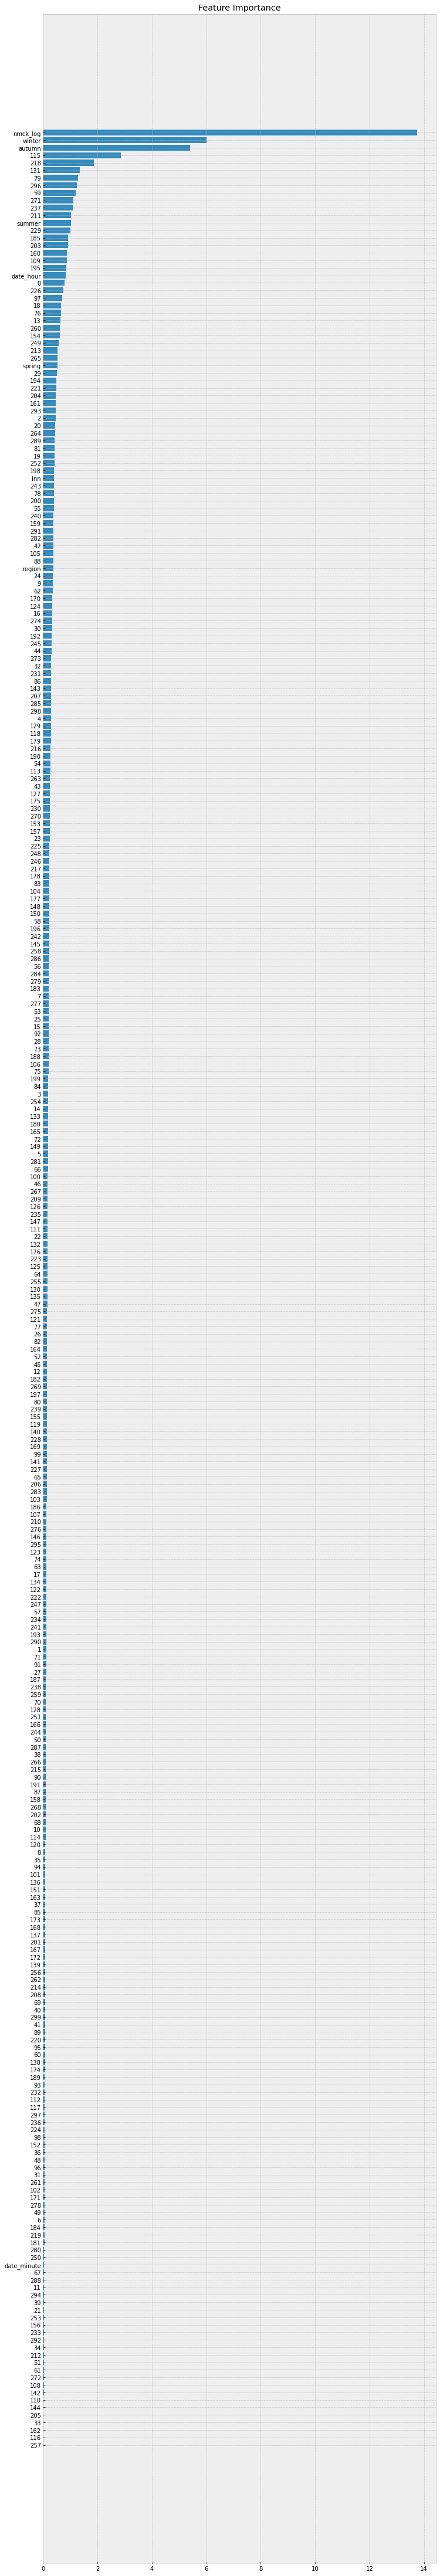

In [33]:
feature_importance = model_CBR.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 80))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [34]:
predicted_y = model_CBR.predict(X_test)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
print("mean_absolute_error", mean_absolute_error(y_test, predicted_y))

mean_absolute_error 0.12356721296983758


y_testпредсказание mean_absolute_error 

In [206]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn import metrics

#X_train, X_test, y_train, y_test
predicted_y = model_CBR.predict(X_test)
#print("r2_score", metrics.r2_score(y_test, predicted_y))
print("mean_absolute_error", mean_absolute_error(y_test, predicted_y))

mean_absolute_error 0.0025146344753249083


In [223]:
plt.figure(figsize=(10,10))
sns.regplot(y_test, predicted_y, fit_reg=True, scatter_kws={"s": 100})

TypeError: regplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 2 keyword-only arguments) were given

<Figure size 720x720 with 0 Axes>

In [245]:
prod_df[prod_df.kpgz.str.len() != 0].groupby("region").count()

status    name   okpd2    kpgz    nmck   price  participans     bet  \
region                                                                        
0            5       5       5       5       5       5            5       5   
1            3       3       3       3       3       3            3       3   
2       204401  204401  204401  204401  204401  204401       204401  204401   
3           17      17      17      17      17      17           17      17   
4            2       2       2       2       2       2            2       2   
5          171     171     171     171     171     171          171     171   
6          116     116     116     116     116     116          116     116   
8            2       2       2       2       2       2            2       2   
9           23      23      23      23      23      23           23      23   

           inn  winter  spring  summer  autumn  date_hour  date_minute  \
region                                                                   
0            5       5       5       5       5          5            5   
1            3       3       3       3       3          3            3   
2       204401  204401  204401  204401  204401     204401       204401   
3           17      17      17      17      17         17           17   
4            2       2       2       2       2          2            2   
5          171     171     171     171     171        171          171   
6          116     116     116     116     116        116          116   
8            2       2       2       2       2          2            2   
9           23      23      23      23      23         23           23   

        price_percent  
region                 
0                   5  
1                   3  
2              204401  
3                  17  
4                   2  
5                 171  
6                 116  
8                   2  
9                  23

<IPython.core.display.JSON object>

In [263]:
import json
with open("../data-20160929T0100.json", "r") as f:
    okpd2 = json.load(f)
    
okpd2_dict = {}

for odin_okpd in okpd2:
    try:
        okpd2_dict[odin_okpd["Kod"]] = odin_okpd["Name"]
    except Exception as e:
        pass
